## 교재 버전
- lightgbm 3.3.2 버전

In [1]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import lightgbm
lightgbm.__version__

'3.3.2'

### 한글폰트 적용

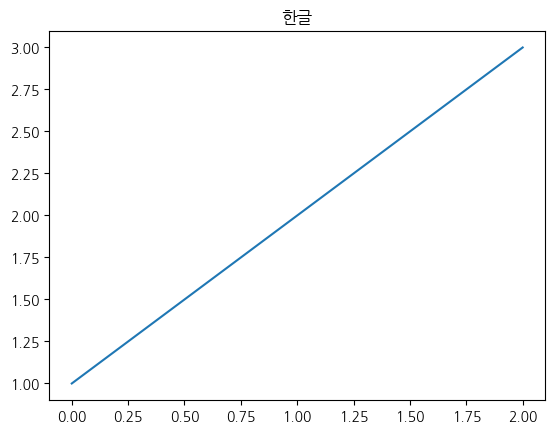

In [3]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

## 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 데이터셋 및 라이브러리 불러오기
- p.214

In [5]:
import pandas as pd
from sklearn.ensemble import VotingClassifier # docs 문서 링크 추가할 것
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer # 데이터 호출
from sklearn.model_selection import train_test_split # 훈련/테스트 데이터 분리
from sklearn.metrics import accuracy_score # 혼동행렬 정확도

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


## 모델 학습

In [6]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현하겠다!
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

# 훈련 데이터 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=1)

# 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561


In [7]:
# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__ # 각 모델의 이름 가져오기 # Docstring 문법
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9561
KNeighborsClassifier 정확도: 0.9474


## 데이터 불러오기

In [8]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()

  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer') # outer join

  # 중복 feature 명에 대해서 원본 feature _1 또는 _2 추가
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스_머신러닝/ch04_data'
    feature_name_df = pd.read_csv(DATA_PATH + '/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(DATA_PATH + '/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(DATA_PATH + '/human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(DATA_PATH + '/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(DATA_PATH + '/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습
rf_clf = RandomForestClassifier(n_estimators = 100, random_state=0, max_depth = 8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

0.9195792331184255


### 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_estimators" : [50, 100, 150],
    "max_depth" : [8, 16, 24],
    "min_samples_leaf" : [1, 6, 12],
    "min_samples_split" : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1) # 병렬처리
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1) # 병렬처리
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=150, min_samples_leaf=6~ )

In [ ]:
print(grid_cv.best_score_)

## GBM
- 가장 큰 단점은 속도가 매우 느림
  + 보완 : XGBoost, LightGBM

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings

warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = get_human_dataset()

### 수행시간 측정

In [ ]:
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print("수행시간: {0:.1f}초 ".format(time.time() - start_time))

## XGBoost
- 참조: https://xgboost.readthedocs.io/en/stable/

In [ ]:
import xgboost
print(xgboost.__version__)

- 교재 228p
  + 파이썬 래퍼 XGBoost 하이퍼 파라미터
    - xgboost.DMatrix() 데이터를 변환해서 사용한다!

### 0. 라이브러리 불러오기 & 환경설정

In [ ]:
# p.232
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')



### 1. 데이터셋 불러오기

In [ ]:
dataset = load_breast_cancer()
X_features = dataset.data # 독립변수
y_label = dataset.target # 종속변수

cancer_df = pd.DataFrame(data = X_features, columns=dataset.feature_names) # 독립변수
cancer_df['target'] = y_label # 종속변수
cancer_df.head(3)

In [ ]:
cancer_df.info()

In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

# p.233 1값인 양성 benign, 0값인 악성 malignant
# 암진단

### 2. 데이터 분리
- 훈련데이터와 테스트 데이터로 분리

In [ ]:
# 종속변수와 독립변수로 분리
X_features = cancer_df.iloc[:, :-1] # 마지막컬럼 제외 후, 나머지 컬럼 가져오기
y_label = cancer_df.iloc[:, -1] # 3 마지막컬럼만 가져오기

# X_features.shape, y_label.shape
# 전체 데이터 중 80% 학습 데이터, 20$ 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

- (p.234) 위에서 만든 X_train, y_train 다시 쪼개서 90%는 학습, 10%는 검증용으로 만듬

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

In [ ]:
X_train.shape, X_tr.shape, X_val.shape, X_test.shape

- X_tr : 훈련 데이터 = (교과서 공부 & EBS 내 연습문제)
- X_val : 검증 데이터 = (중간고사, 기말고사)
- X_test : 테스트 데이터 (평가원 모의고사)

- 실제 수능 점수


### 3. 데이터 변환 (XGBoost 객체)

In [ ]:
# p.234, 핵심코드!
dtr = xgb.DMatrix(data = X_tr, label=y_tr)
dval = xgb.DMatrix(data = X_val, label=y_val)
dtest = xgb.DMatrix(data = X_test, label=y_test)

### 4. 모델링

In [ ]:
# p.235
params = {
    'max_depth' : 3,
    'eta' : 0.05,
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss' # 오차
}

num_rounds = 300

# p236
# 훈련 / 검증 데이터셋
eval_list = [(dtr, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds
                      , early_stopping_rounds=50, evals = eval_list)

### 5. 예측

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ] # 리스트 컴프리헨션
print('예측값 10개만 표시:',preds[:10])

### 6. 평가

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# p.237
get_clf_eval(y_test, preds, pred_probs)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## LightGBM, 사이킷런 래퍼


### Step 0. 라이브러리 불러오기 & 환경설정

In [ ]:
# p.232
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Step 1. 데이터셋 불러오기

In [ ]:
dataset = load_breast_cancer()
X_features = dataset.data # 독립변수
y_label = dataset.target # 종속변수

cancer_df = pd.DataFrame(data = X_features, columns=dataset.feature_names) # 독립변수
cancer_df['target'] = y_label # 종속변수

### Step 2. 데이터 분리

In [ ]:
# 종속변수와 독립변수로 분리
X_features = cancer_df.iloc[:, :-1] # 마지막컬럼 제외 후, 나머지 컬럼 가져오기
y_label = cancer_df.iloc[:, -1] # 3 마지막컬럼만 가져오기

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

X_train.shape, X_tr.shape, X_val.shape, X_test.shape

### Step 3. 모델링
- 사이킷런 래퍼 형태로 진행


In [ ]:
# p.251
labm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
labm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50,
                 eval_metric='logloss',
                 eval_set = evals, verbose=True)

### Step 4. 예측

In [ ]:
preds = labm_wrapper.predict(X_test)
pred_proba = labm_wrapper.predict_proba(X_test)[:, 1]

### Step 5. 평가

In [ ]:
# p.237
get_clf_eval(y_test, preds, pred_probs)

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(labm_wrapper, ax=ax)